# MODNet 'matbench_expt_is_metal' benchmarking

In [1]:
from matminer.datasets import get_all_dataset_info

# Get dataset info from matminer
info = get_all_dataset_info("matbench_mp_is_metal")

# Check out the info about the dataset.
print(info)

Dataset: matbench_mp_is_metal
Description: Matbench v0.1 test dataset for predicting DFT metallicity from structure. Adapted from Materials Project database. Removed entries having a formation energy (or energy above the convex hull) more than 150meV and those containing noble gases. Retrieved April 2, 2019. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	is_metal: Target variable. 1 if the compound is a metal, 0 if the compound is not a metal. Metallicity determined with pymatgen
	structure: Pymatgen Structure of the material.
Num Entries: 106113
Reference: A. Jain*, S.P. Ong*, G. Hautier, W. Chen, W.D. Richards, S. Dacek, S. Cholia, D. Gunter, D. Skinner, G. Ceder, K.A. Persson (*=equal contributions)
The Materials Project: A materials genome approach to accelerating materials innovation
APL Materials, 2013, 1(1), 011002.
doi:10.1063/1.4812323
Bibt

In [2]:
from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from IPython.display import Markdown
from matminer.datasets import load_dataset
from pymatgen.core import Composition

from modnet.preprocessing import MODData
#from modnet.models import MODNetModel
from modnet.featurizers import MODFeaturizer
from modnet.featurizers.presets import DeBreuck2020Featurizer

#os.environ["CUDA_VISIBLE_DEVICES"] = "1"


If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



In [3]:
import modnet
modnet.__version__

'0.1.8'

In [4]:
Markdown(filename="./README.md")

# matbench_mp_is_metal

## Introduction

- Classification task (1: metal, 0: non-metal)
- 106,113 compounds with structure

Results to beat:

| Method | ROC_AUC |
|:-------|-----------------:|
| AM     | - |
| RF     | -  |
| Dummy  | -  |

## Notes



## To-do



## Results

| Method | ROC_AUC |
|:-------|---------------------:|
| Rough MODNet baseline   | - |


## Data exploration

In [ ]:
df = load_dataset("matbench_mp_is_metal")

In [ ]:
df['composition'] = df['structure'].map(lambda x : x.composition)
df.columns

In [ ]:
df.head()

### Composition space

In [ ]:
## /!\ the interpretation is different from the steels
values = df["composition"].apply(lambda s: s.get_el_amt_dict())
elements = defaultdict(float)
proportions = defaultdict(list)
for s in values:
    tot = np.sum(list(s.values()))
    for e in s:
        elements[e] += 1
        proportions[e] += [s[e]/tot]
        
for elem in elements:
    elements[elem] /= len(values)

mean_proportions = {elem: np.mean(proportions[elem]) for elem in proportions}
mean_proportions = dict(sorted(mean_proportions.items(), key=lambda x: x[1], reverse=True))
elements = dict(sorted(elements.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(facecolor="w",figsize=(22,7));
#ax.set_yscale("log")
ax.bar(elements.keys(), elements.values())
ax.set_ylabel(" compound fraction containing element e");

In [ ]:
# distribution of element proportions across compositions
fig, axis = plt.subplots(11, 8, facecolor="w", figsize=(20, 20))
for ax, elem in zip(axis.flatten(), mean_proportions):
    ax.hist(
        proportions[elem], 
        bins=np.linspace(0, 1, 50), 
        density=False, 
    )
    ax.set_xlim(-0.1, 1.1)
    ax.text(0.75, 0.8, elem, fontsize=24, transform=ax.transAxes, )
    #ax[axis].set_ylim(0, 312)

plt.tight_layout()

### Target space

In [ ]:
df['is_metal'] = df['is_metal'].map(int)
df.describe()

In [ ]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["is_metal"]);
ax.set_ylabel("Frequency")
ax.set_xlabel("is metal")

## Featurization and feature selection

First, we define some convenience classes that pass wraps composition data in a fake structure containe, and we define a composition only featurizer preset based on `DeBreuck2020Featurizer`.

In [ ]:
PRECOMPUTED_MODDATA = "./precomputed/mp_is_metal_benchmark_moddata.pkl.gz"

if os.path.isfile(PRECOMPUTED_MODDATA):
    data = MODData.load(PRECOMPUTED_MODDATA)
else:
    # Use a fresh copy of the dataset
    df = load_dataset("matbench_dielectric")
    
    data = MODData(
        structures=df["structure"].tolist(), 
        targets=df["n"].tolist(), 
        target_names=["n"],
        featurizer=DeBreuck2020Featurizer(n_jobs=8)
    )
    data.featurize()
    data.save(PRECOMPUTED_MODDATA)
    # data.feature_selection(n=-1)

In [ ]:
# Look at some of the top features chosen by MODNet
for feat in data.optimal_features[:10]:
    fig, ax = plt.subplots(facecolor="w")
    plt.scatter(data.df_featurized[feat], data.df_targets, alpha=0.5)
    plt.xlabel(feat)
    plt.ylabel("is_metal")

## Training

This is a very small dataset, so we must make judicious use of what data there is. First, let's generate test folds according to [matbench's suggestions](https://hackingmaterials.lbl.gov/automatminer/datasets.html#benchmarking-and-reporting-your-algorithm):

In [ ]:
try:
    plot_benchmark
except:
    os.chdir("..")
    from modnet_matbench.utils import *

In [ ]:
from sklearn.model_selection import KFold
#from modnet.models import MODNetModel
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

data.df_targets['is_metal'] = data.df_targets['is_metal'].map(int)

best_settings = {
    "num_neurons": [[32], [32], [8], [8]],
    "n_feat": 120,
    "lr": 0.005,
    "epochs": 100,
    "verbose": 0,
    "act": "elu",
    "batch_size": 128,
    "num_classes": {'is_metal':2},
    #"loss": "binary_crossentropy",
    #"xscale": "standard",
}

results = matbench_benchmark(data, [[["is_metal"]]], {"is_metal": 1}, best_settings,classification=True)
np.mean(results['scores'])

In [ ]:
for i,c in zip(range(5),['b','k','r','g','y']):
    plt.plot(results["models"][i].history.history["loss"][50:],c=c)
    #plt.plot(results["models"][i].history.history["val_loss"][50:],':',c=c)

## Feature selection

In [24]:
model = results['models'][0]

In [25]:
def process(data):
    x = data.get_featurized_df()[model.optimal_descriptors[:model.n_feat]]
    x = model._scaler.transform(x)
    x = np.nan_to_num(x)
    return x

In [26]:
try:
    matbench_kfold_splits()
except:
    os.chdir("..")
    from modnet_matbench.utils import matbench_kfold_splits


In [27]:
import shap
shap.initjs()
for train, test in matbench_kfold_splits(data):
    train_moddata, test_moddata = data.split((train, test))
    break

X_train = shap.sample(process(train_moddata))
explainer = shap.KernelExplainer(model.model.predict, X_train)

In [28]:
shap_values = explainer.shap_values(X_train, nsamples=1000)

INFO:shap:num_full_subsets = 0
INFO:shap:remaining_weight_vector = [0.1890534  0.09534867 0.06412338 0.04851813 0.03916106 0.03292822
 0.02848077 0.02514931 0.02256193 0.02049551 0.01880806 0.01740492
 0.01622056 0.01520818 0.01433346 0.01357066 0.01290011 0.01230651
 0.01177776 0.01130422 0.01087807 0.01049292 0.01014348 0.00982536
 0.00953487 0.00926889 0.00902477 0.00880024 0.00859334 0.00840237
 0.00822588 0.00806257 0.00791133 0.00777115 0.00764118 0.00752064
 0.00740885 0.00730519 0.00720914 0.00712019 0.00703793 0.00696197
 0.00689195 0.00682758 0.00676858 0.0067147  0.00666571 0.00662144
 0.00658169 0.00654633 0.00651521 0.00648822 0.00646527 0.00644627
 0.00643114 0.00641985 0.00641234 0.00640859]
INFO:shap:num_paired_subset_sizes = 58
INFO:shap:weight_left = 0.9999999999999999
INFO:shap:np.sum(w_aug) = 116.99999999999997
INFO:shap:np.sum(self.kernelWeights) = 1.0
INFO:shap:phi = [ 0.07475627  0.          0.          0.          0.          0.
  0.          0.          0.06279

In [31]:
shap.force_plot(
    explainer.expected_value[0], 
    shap_values[0], 
    feature_names=model.optimal_descriptors[:model.n_feat], 
    out_names=["is_not_metal"],
)

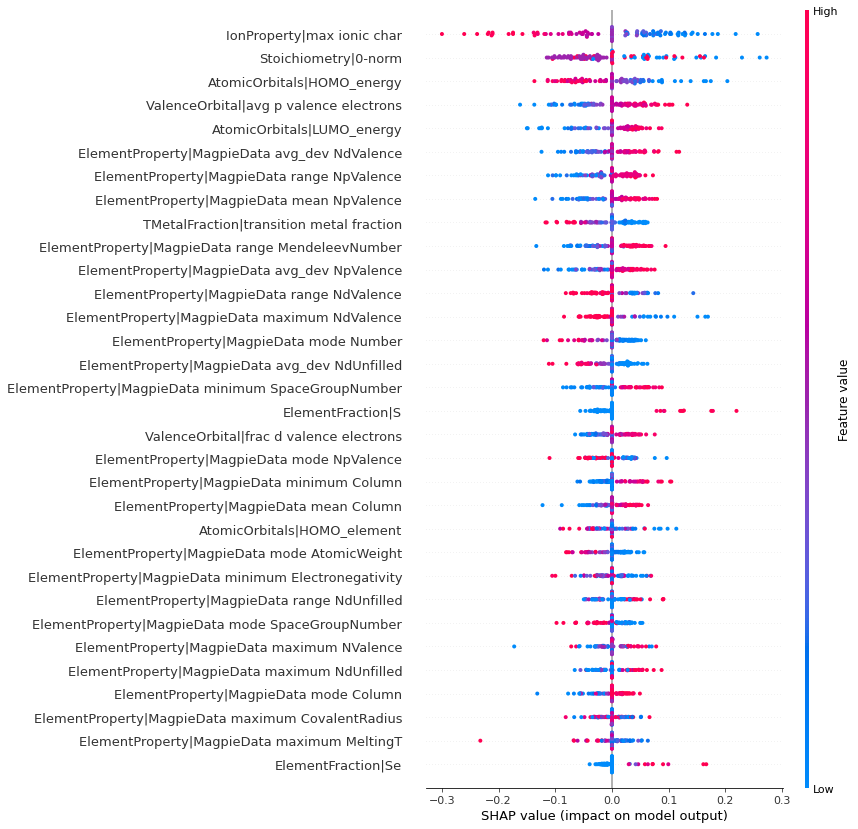

In [32]:
shap.summary_plot(shap_values[0], X_train, max_display=32, plot_type="dot", feature_names=model.optimal_descriptors[:model.n_feat])